In [1]:
import os
import random
from datetime import datetime
import ast
import copy

import gc
import yaml
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.tensorboard import SummaryWriter
import torch.optim.lr_scheduler as lr_scheduler

from preprocessing.final_preprocessing import serve_data, serve_data_sine, serve_data_kmeans

from models.transformer_encoder import TransEncoder
from models.baseline import BaseLineModel

from ddpm.ddpm import GaussianDiffusion1D

from evaluation.pca_tsne import visualize_all_customers, visual_evaluation
from evaluation.jsd import plot_jsd
from evaluation.rmse import rmse

gc.collect()

random.seed(42)
np.random.seed(42)

In [2]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Parameters

In [3]:
config_path = "./config_baseline.yml"
with open(config_path, 'r') as f:
    config = yaml.full_load(f)

date = datetime.today().strftime('%Y-%m-%d-%H-%M')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = config["seq_len"]
epochs = config["epochs"]
timesteps = config["timesteps"]
batch_size_config = config["batch_size"]
latent_dim = config["latent_dim"]
num_layers = config["num_layers"]
n_heads = config["n_heads"]
beta_schedule = config["beta_schedule"]
objective = config["objective"]
model_name = config["model_name"]
cond_model = config["cond_model"]
lr = 5*16**-4
betas = tuple_of_floats = ast.literal_eval(config["betas"])
save_rate = int(config["save_rate"])

assert model_name in ["BaseLine", "TransEncoder"], "Chosen  model was not valid, the options are BaseLine or TransEncoder"
assert cond_model in {"mlp", "te", "fft", "stft"}, "Chosen conditioning model was not valid, the options are mlp, te, fft and stft"

log_file_name = f"{model_name}_{cond_model}_{str(date)}"
tb_writer = f"./logging/tensorboard/{log_file_name}"

# Data

In [4]:
train_loader, test_loader, train_cols, test_cols, test_data, features, cond_features = serve_data_kmeans(seq_len, batch_size_config)

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


(13129, 10, 12)


In [5]:
# train_loader, test_loader, features , test_data = serve_data_sine(batch_size_config, seq_len, var=1000)
# cond_features = 10

In [6]:
#train_loader, test_loader, train_cols, test_cols, test_data, features, cond_features = serve_data(types=["re"],seq_len=seq_len, batch_size=batch_size_config)

# Model

In [25]:
model = BaseLineModel(seq_len=seq_len, hidden_dim=latent_dim, cond_dim=cond_features, cond_model=cond_model, device=device, channels=features)

ddpm = GaussianDiffusion1D(model, seq_length = seq_len, timesteps = timesteps, objective = objective, loss_type = 'l2', beta_schedule = beta_schedule)
ddpm = ddpm.to(device)

optim = torch.optim.Adam(ddpm.parameters(), lr = lr)
scheduler = lr_scheduler.StepLR(optim, step_size=1000, gamma=0.9)

writer = SummaryWriter(tb_writer)

## Train

In [8]:
run_path = f"./logging/weights/{log_file_name}"
os.makedirs(run_path)

rmse_list = []
lowest_loss = 100000
step=0

for running_epoch in tqdm(range(epochs)):
    running_loss = 0.0
    
    for i, (data, cond_data) in enumerate(train_loader):
        data = data.to(device)
        
        cond_data = cond_data.float()
        cond_data = cond_data.to(device)
                
        batch_size = data.shape[0]
        
        optim.zero_grad()
        
        loss = ddpm(data, None)
        loss.backward()
        
        optim.step()
        scheduler.step()
                
        running_loss += loss.item()

        
        if loss.item() < lowest_loss:
            lowest_loss = loss.item()
            best_model_params = model.state_dict()
        
        writer.add_scalar("Batch Training Loss", loss, global_step=step)
        step += 1
    
    avg_epoch_loss = running_loss / len(train_loader)
    writer.add_scalar("Epoch Training Loss", avg_epoch_loss, running_epoch)
    
    if running_epoch % 5 ==0:        
        with torch.no_grad():
            sample = ddpm.sample(batch_size_config)
        
        p = sample.cpu()
        q = torch.from_numpy(test_data[:batch_size_config])
            
        rmse_res = rmse(p,q).item()
        rmse_list.append(rmse_res)
        
        writer.add_scalar('Epoch Training RMSE', rmse_res, running_epoch)
        
        print(f'Epoch: {running_epoch+1}, Epoch Loss: {avg_epoch_loss:.4f}, RMSE: {rmse_res:.4f}')
    
    else:
        print(f'Epoch: {running_epoch+1}, Epoch Loss: {avg_epoch_loss:.4f}')
            
            
    if running_epoch % save_rate == 0:
        torch.save({
            'epoch': running_epoch+1,
            'diffusion_state_dict': ddpm.state_dict(),
            'diffusion_optim_state_dict': optim.state_dict()
            }, os.path.join(f'{run_path}', f'ep_{running_epoch}_mse_{avg_epoch_loss:.3f}_weights.pth'))

torch.save(best_model_params, os.path.join(f'{run_path}', 'best_model_weights.pth'))

  2%|▏         | 1/50 [00:04<03:56,  4.82s/it]

Epoch: 1, Epoch Loss: 1.1673, RMSE: 0.7810


  4%|▍         | 2/50 [00:05<02:07,  2.66s/it]

Epoch: 2, Epoch Loss: 1.0051


  6%|▌         | 3/50 [00:07<01:32,  1.97s/it]

Epoch: 3, Epoch Loss: 1.0016


  8%|▊         | 4/50 [00:08<01:15,  1.65s/it]

Epoch: 4, Epoch Loss: 1.0030


 10%|█         | 5/50 [00:09<01:06,  1.47s/it]

Epoch: 5, Epoch Loss: 1.0022


 12%|█▏        | 6/50 [00:13<01:49,  2.49s/it]

Epoch: 6, Epoch Loss: 1.0017, RMSE: 0.7718


 14%|█▍        | 7/50 [00:15<01:28,  2.05s/it]

Epoch: 7, Epoch Loss: 0.9911


 16%|█▌        | 8/50 [00:16<01:13,  1.76s/it]

Epoch: 8, Epoch Loss: 0.9816


 18%|█▊        | 9/50 [00:17<01:04,  1.56s/it]

Epoch: 9, Epoch Loss: 0.9777


 20%|██        | 10/50 [00:18<00:57,  1.43s/it]

Epoch: 10, Epoch Loss: 0.9760


 22%|██▏       | 11/50 [00:23<01:34,  2.41s/it]

Epoch: 11, Epoch Loss: 0.9733, RMSE: 0.7459


 24%|██▍       | 12/50 [00:24<01:17,  2.03s/it]

Epoch: 12, Epoch Loss: 0.9720


 26%|██▌       | 13/50 [00:25<01:05,  1.77s/it]

Epoch: 13, Epoch Loss: 0.9736


 28%|██▊       | 14/50 [00:26<00:57,  1.59s/it]

Epoch: 14, Epoch Loss: 0.9715


 30%|███       | 15/50 [00:27<00:51,  1.46s/it]

Epoch: 15, Epoch Loss: 0.9715


 32%|███▏      | 16/50 [00:32<01:20,  2.38s/it]

Epoch: 16, Epoch Loss: 0.9711, RMSE: 0.7500


 34%|███▍      | 17/50 [00:33<01:06,  2.02s/it]

Epoch: 17, Epoch Loss: 0.9703


 36%|███▌      | 18/50 [00:34<00:56,  1.76s/it]

Epoch: 18, Epoch Loss: 0.9715


 38%|███▊      | 19/50 [00:35<00:49,  1.59s/it]

Epoch: 19, Epoch Loss: 0.9705


 40%|████      | 20/50 [00:36<00:43,  1.46s/it]

Epoch: 20, Epoch Loss: 0.9720


 42%|████▏     | 21/50 [00:41<01:10,  2.44s/it]

Epoch: 21, Epoch Loss: 0.9706, RMSE: 0.7538


 44%|████▍     | 22/50 [00:42<00:57,  2.06s/it]

Epoch: 22, Epoch Loss: 0.9701


 46%|████▌     | 23/50 [00:44<00:48,  1.79s/it]

Epoch: 23, Epoch Loss: 0.9686


 48%|████▊     | 24/50 [00:45<00:41,  1.61s/it]

Epoch: 24, Epoch Loss: 0.9708


 50%|█████     | 25/50 [00:46<00:36,  1.48s/it]

Epoch: 25, Epoch Loss: 0.9698


 52%|█████▏    | 26/50 [00:50<00:58,  2.42s/it]

Epoch: 26, Epoch Loss: 0.9720, RMSE: 0.7569


 54%|█████▍    | 27/50 [00:52<00:47,  2.04s/it]

Epoch: 27, Epoch Loss: 0.9697


 56%|█████▌    | 28/50 [00:53<00:39,  1.78s/it]

Epoch: 28, Epoch Loss: 0.9674


 58%|█████▊    | 29/50 [00:54<00:33,  1.60s/it]

Epoch: 29, Epoch Loss: 0.9686


 60%|██████    | 30/50 [00:55<00:29,  1.47s/it]

Epoch: 30, Epoch Loss: 0.9678


 62%|██████▏   | 31/50 [01:00<00:46,  2.46s/it]

Epoch: 31, Epoch Loss: 0.9698, RMSE: 0.7636


 64%|██████▍   | 32/50 [01:01<00:37,  2.08s/it]

Epoch: 32, Epoch Loss: 0.9679


 66%|██████▌   | 33/50 [01:02<00:30,  1.81s/it]

Epoch: 33, Epoch Loss: 0.9680


 68%|██████▊   | 34/50 [01:03<00:25,  1.62s/it]

Epoch: 34, Epoch Loss: 0.9698


 70%|███████   | 35/50 [01:05<00:22,  1.49s/it]

Epoch: 35, Epoch Loss: 0.9673


 72%|███████▏  | 36/50 [01:09<00:33,  2.43s/it]

Epoch: 36, Epoch Loss: 0.9679, RMSE: 0.7618


 74%|███████▍  | 37/50 [01:10<00:26,  2.05s/it]

Epoch: 37, Epoch Loss: 0.9673


 76%|███████▌  | 38/50 [01:12<00:21,  1.79s/it]

Epoch: 38, Epoch Loss: 0.9682


 78%|███████▊  | 39/50 [01:13<00:17,  1.61s/it]

Epoch: 39, Epoch Loss: 0.9665


 80%|████████  | 40/50 [01:14<00:14,  1.48s/it]

Epoch: 40, Epoch Loss: 0.9678


 82%|████████▏ | 41/50 [01:19<00:22,  2.47s/it]

Epoch: 41, Epoch Loss: 0.9679, RMSE: 0.7684


 84%|████████▍ | 42/50 [01:20<00:16,  2.08s/it]

Epoch: 42, Epoch Loss: 0.9692


 86%|████████▌ | 43/50 [01:21<00:12,  1.82s/it]

Epoch: 43, Epoch Loss: 0.9695


 88%|████████▊ | 44/50 [01:22<00:09,  1.63s/it]

Epoch: 44, Epoch Loss: 0.9685


 90%|█████████ | 45/50 [01:24<00:07,  1.50s/it]

Epoch: 45, Epoch Loss: 0.9689


 92%|█████████▏| 46/50 [01:28<00:09,  2.44s/it]

Epoch: 46, Epoch Loss: 0.9683, RMSE: 0.7553


 94%|█████████▍| 47/50 [01:29<00:06,  2.07s/it]

Epoch: 47, Epoch Loss: 0.9689


 96%|█████████▌| 48/50 [01:31<00:03,  1.80s/it]

Epoch: 48, Epoch Loss: 0.9633


 98%|█████████▊| 49/50 [01:32<00:01,  1.62s/it]

Epoch: 49, Epoch Loss: 0.9718


100%|██████████| 50/50 [01:33<00:00,  1.87s/it]

Epoch: 50, Epoch Loss: 0.9666


In [29]:
model.load_state_dict(torch.load(os.path.join(f'{run_path}', 'best_model_weights.pth')))
ddpm = GaussianDiffusion1D(model, seq_length = seq_len, timesteps = timesteps, objective = objective, loss_type = 'l2', beta_schedule = beta_schedule)
ddpm = ddpm.to(device)

C:\Users\Arne\AppData\Local\Temp\ipykernel_14264\1081204139.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(f'{run_path}', 

## Sampling

In [30]:
with torch.no_grad():
    samples = ddpm.sample(batch_size_config)
    samples = samples.cpu().numpy()

print(f"Samples shape: {samples.shape}")

sampling loop time step: 100%|██████████| 500/500 [00:03<00:00, 154.15it/s]


Samples shape: (256, 10, 12)


# Evaluation
## Without Conditioning
### Train

In [31]:
real_data_train, real_cond_data_train = next(iter(train_loader))
real_data_test, real_cond_data_test = next(iter(test_loader))

real_cond_data_train.shape, real_data_test.shape

(torch.Size([256, 10, 12]), torch.Size([256, 10, 12]))

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


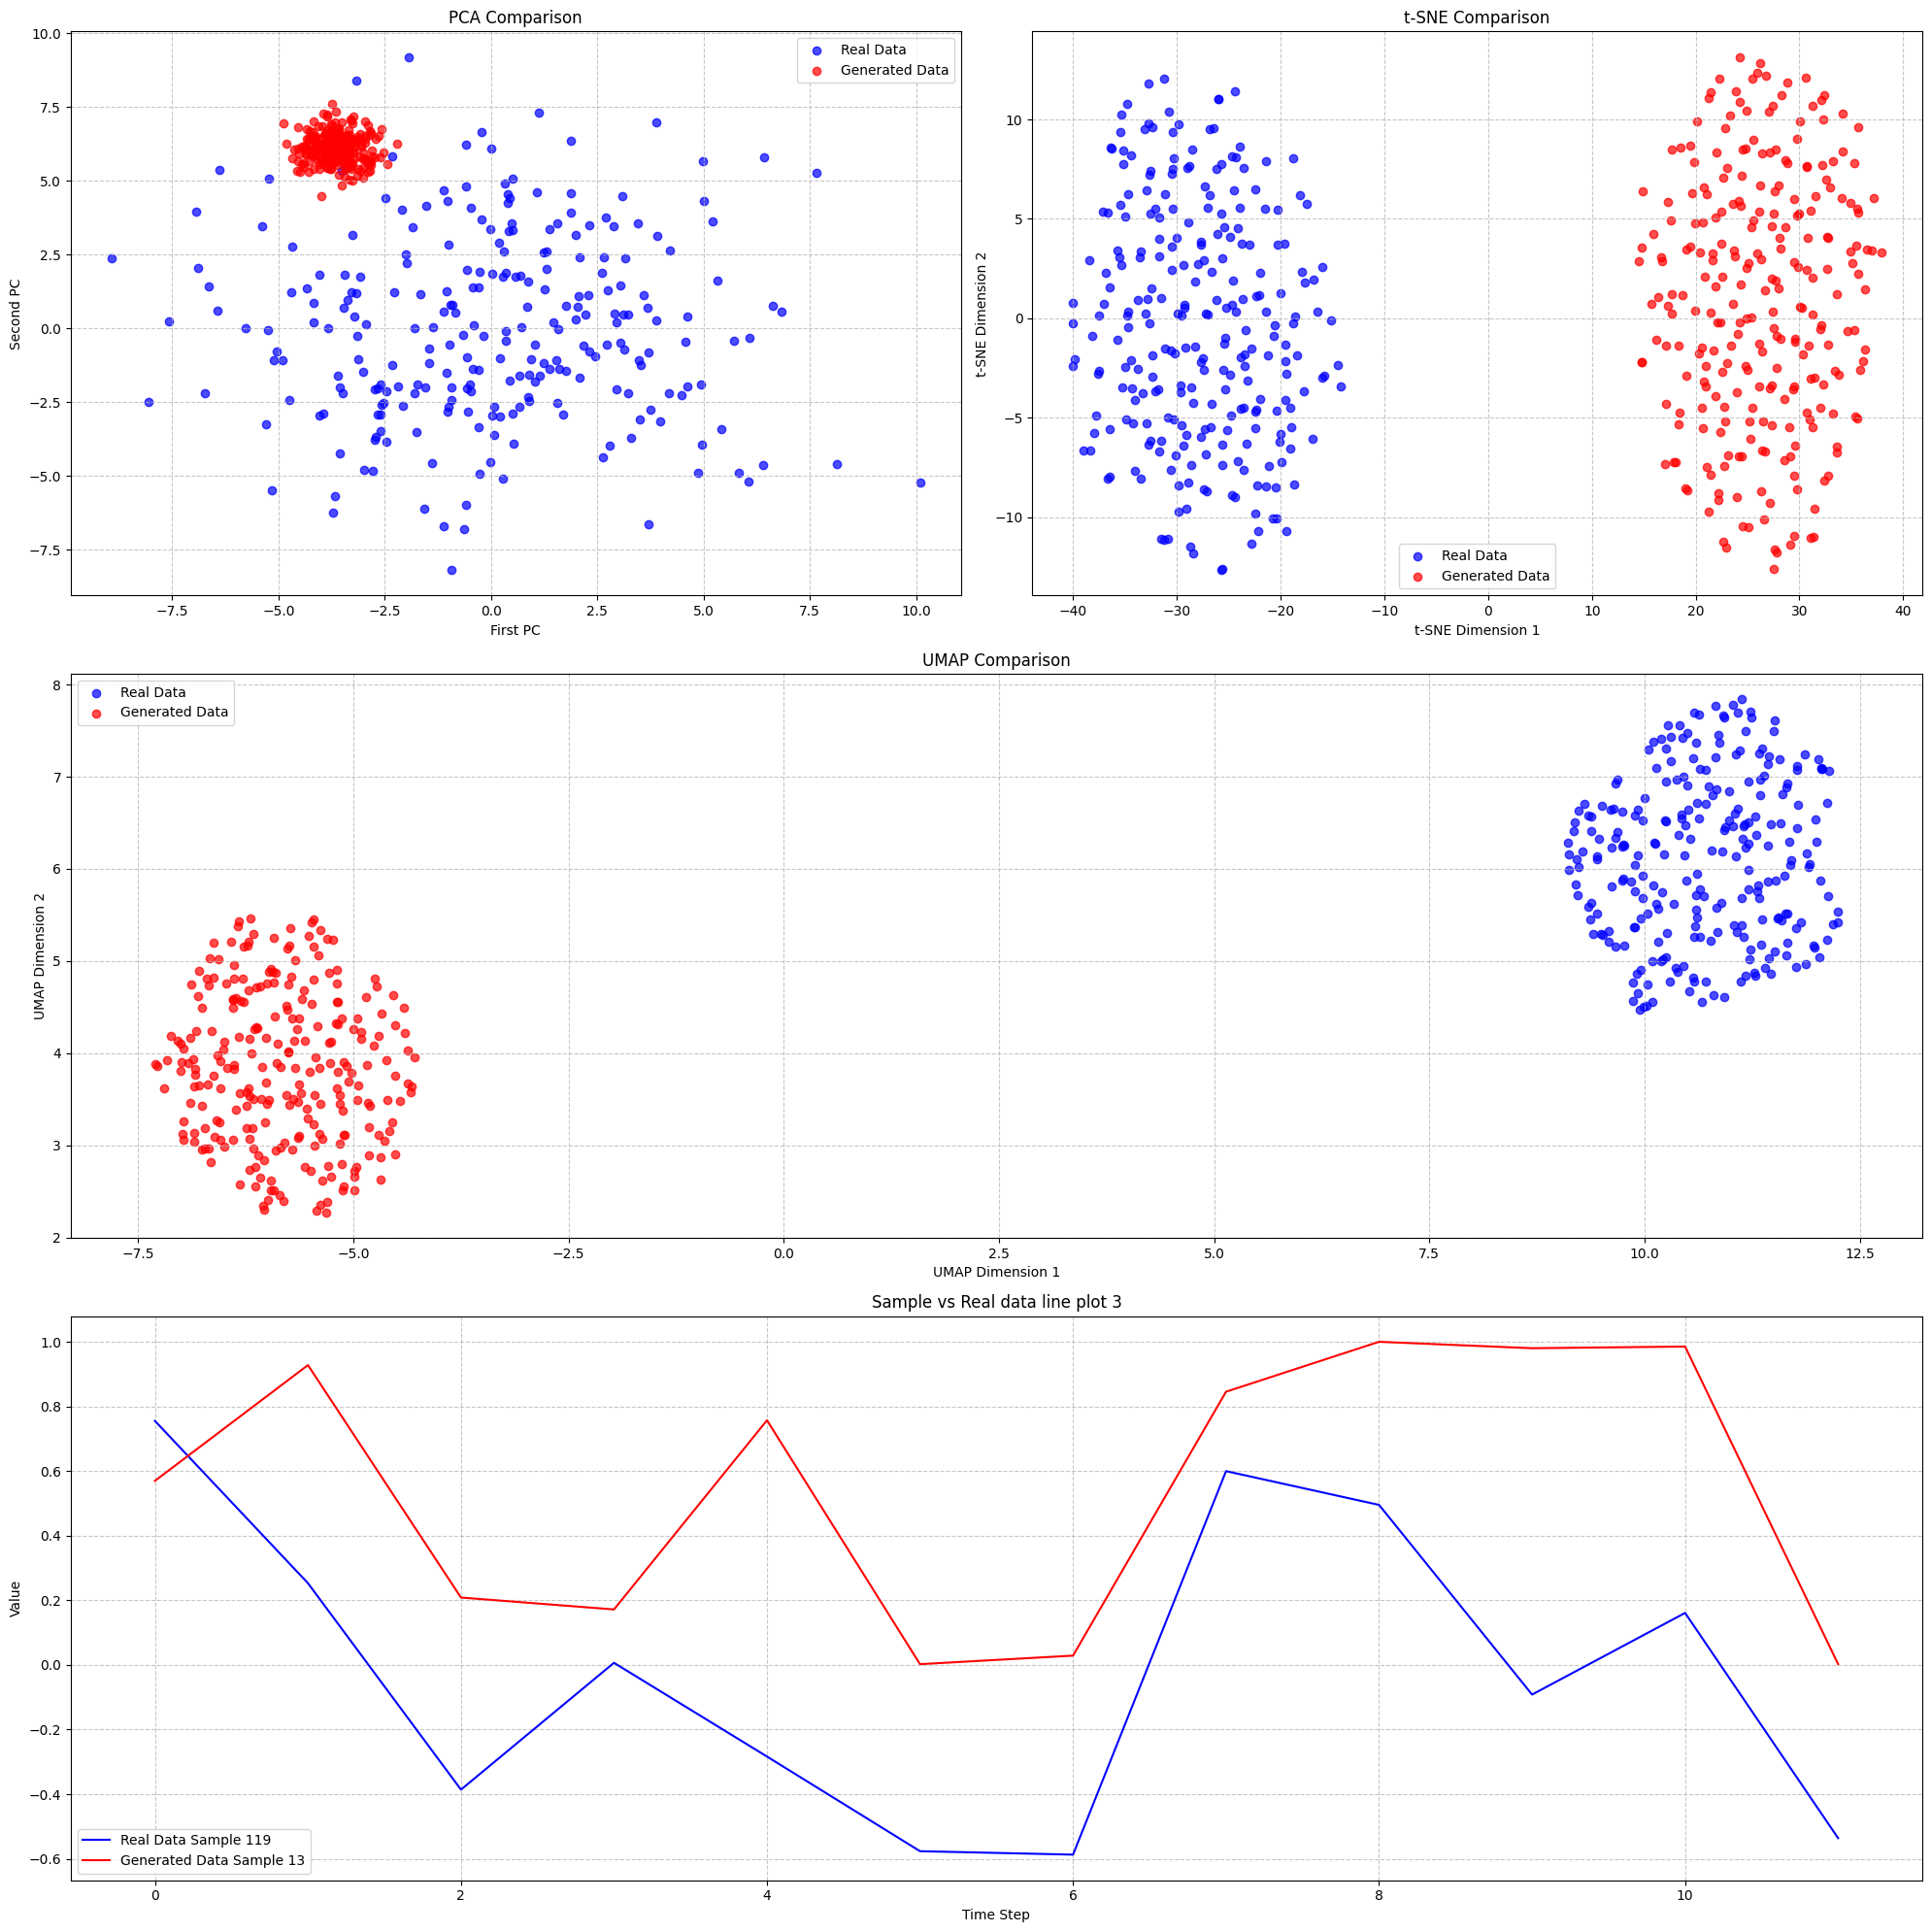

In [32]:
visual_evaluation(real_data_train, samples, log_file_name, False, "train")

### Test

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


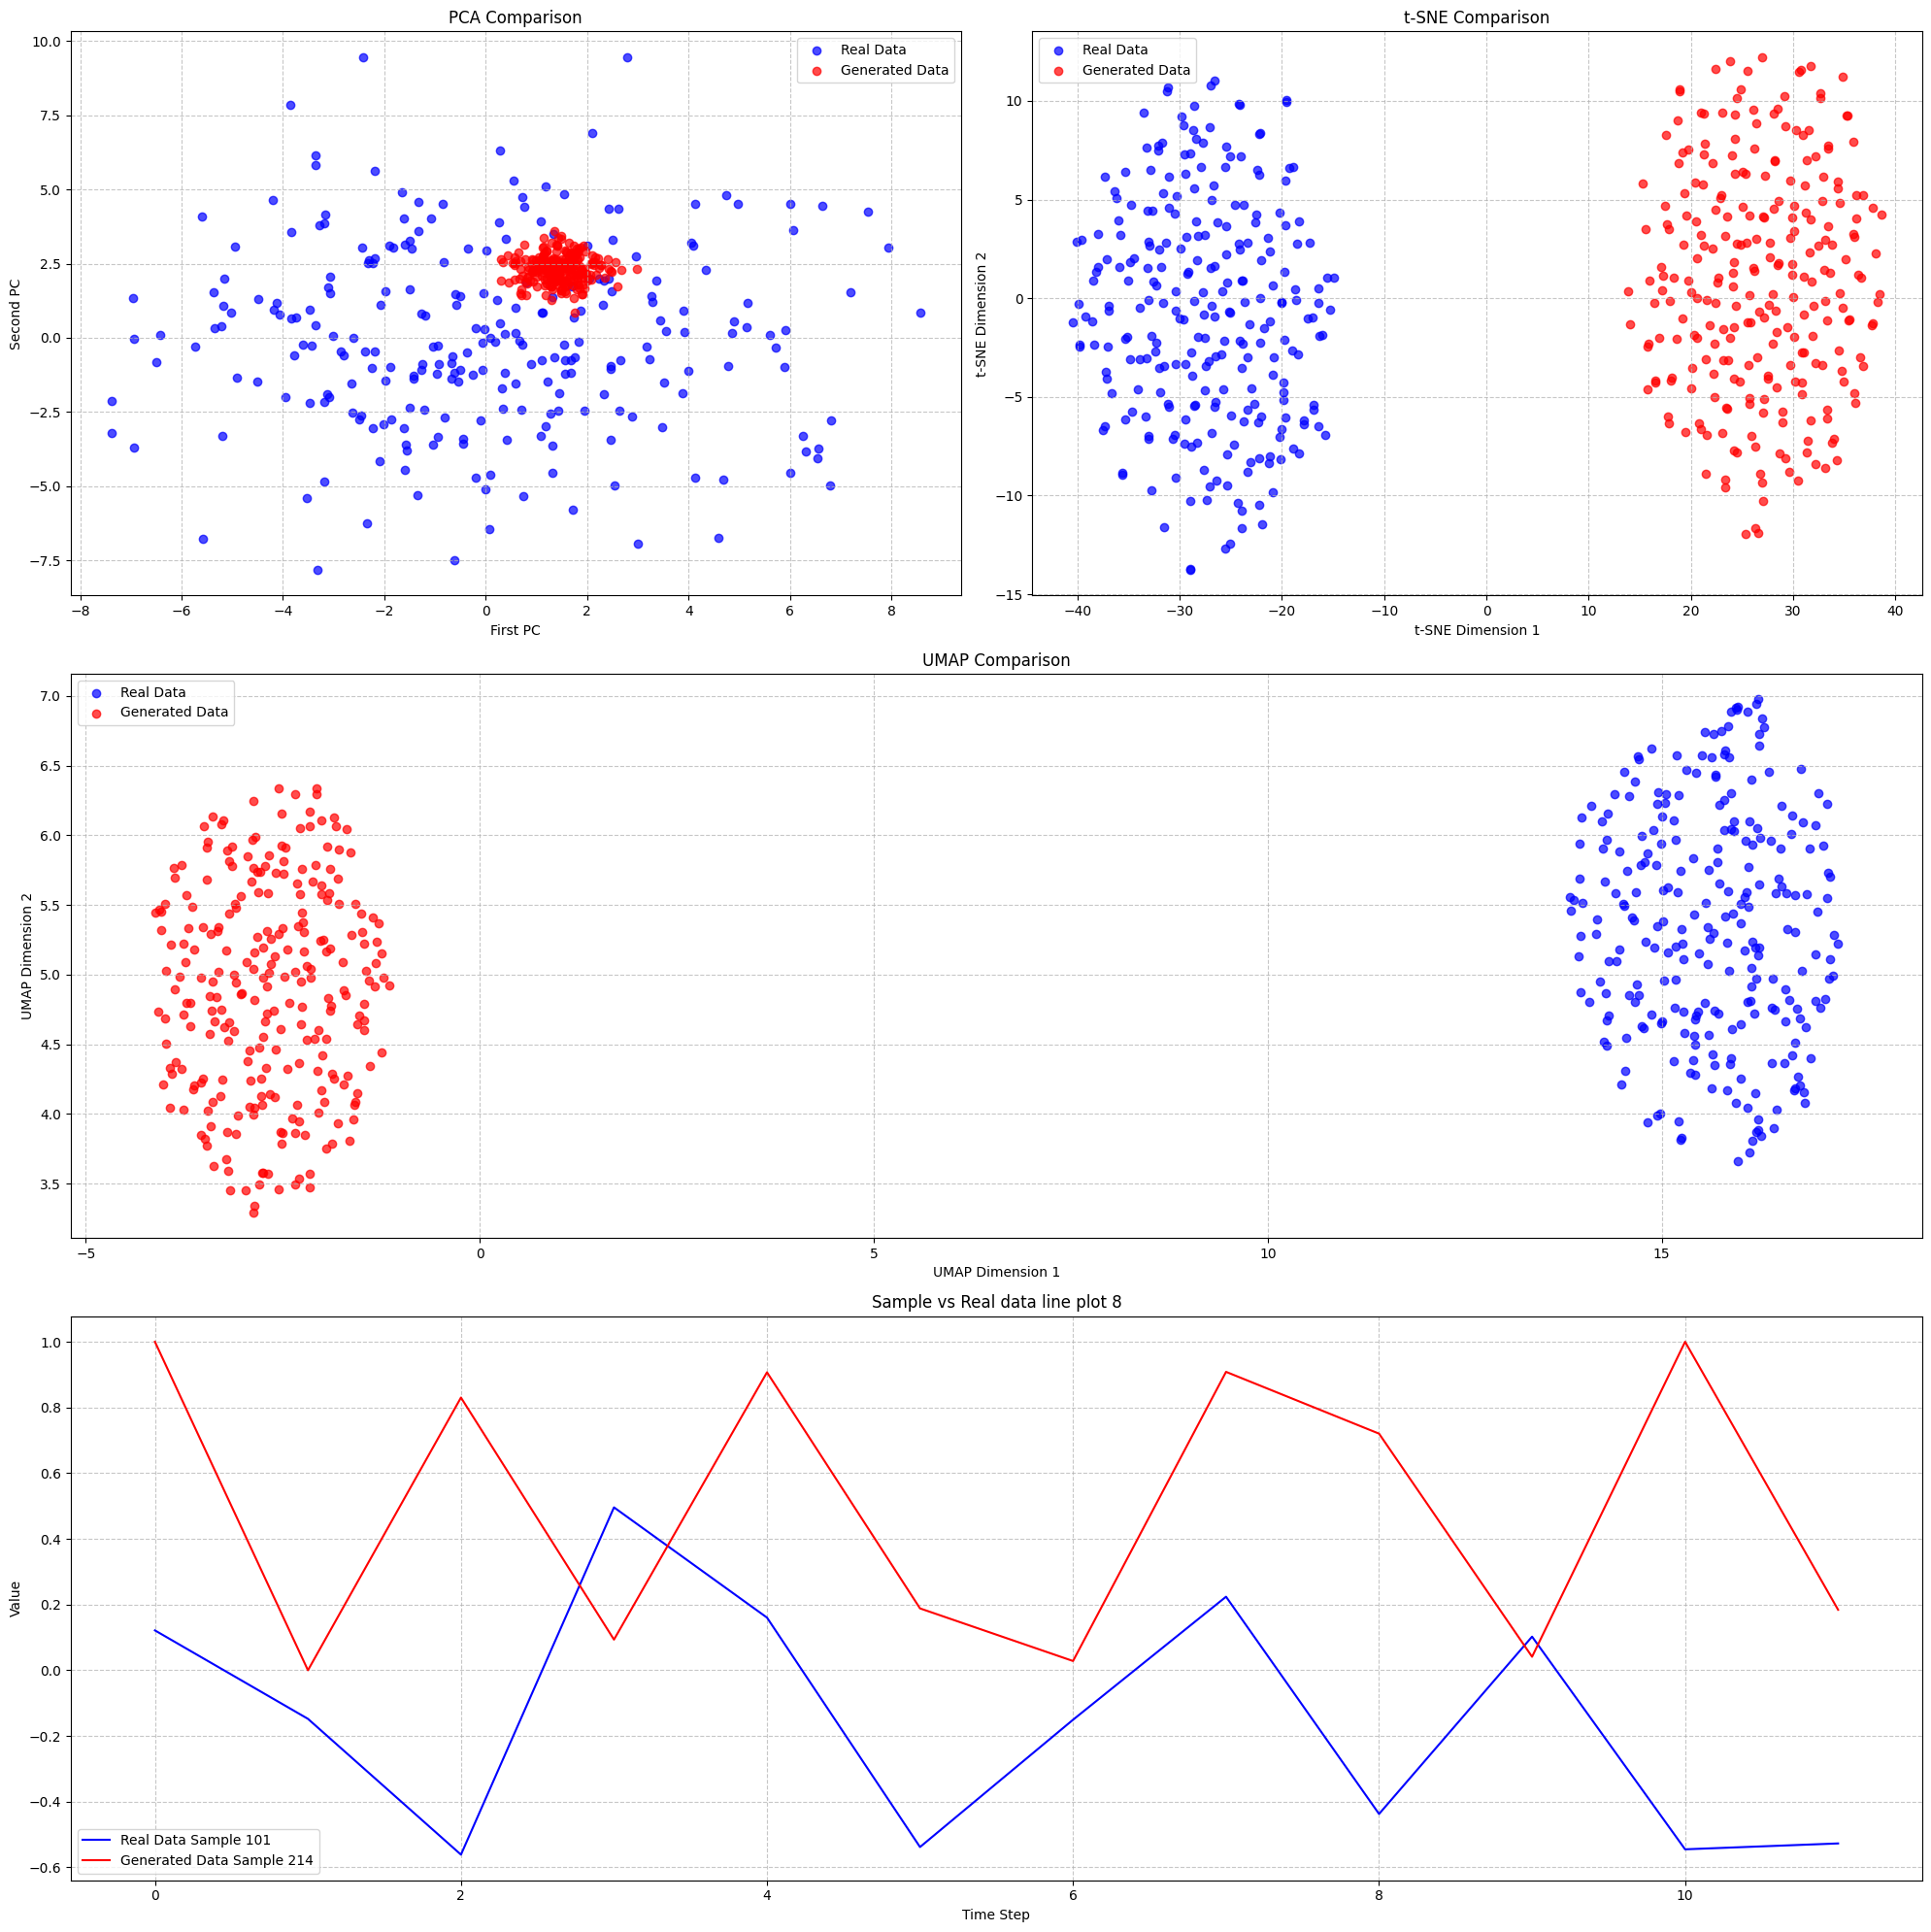

In [33]:
visual_evaluation(real_data_test, samples, log_file_name, False, "test")

### Jensen-Shannon Divergence

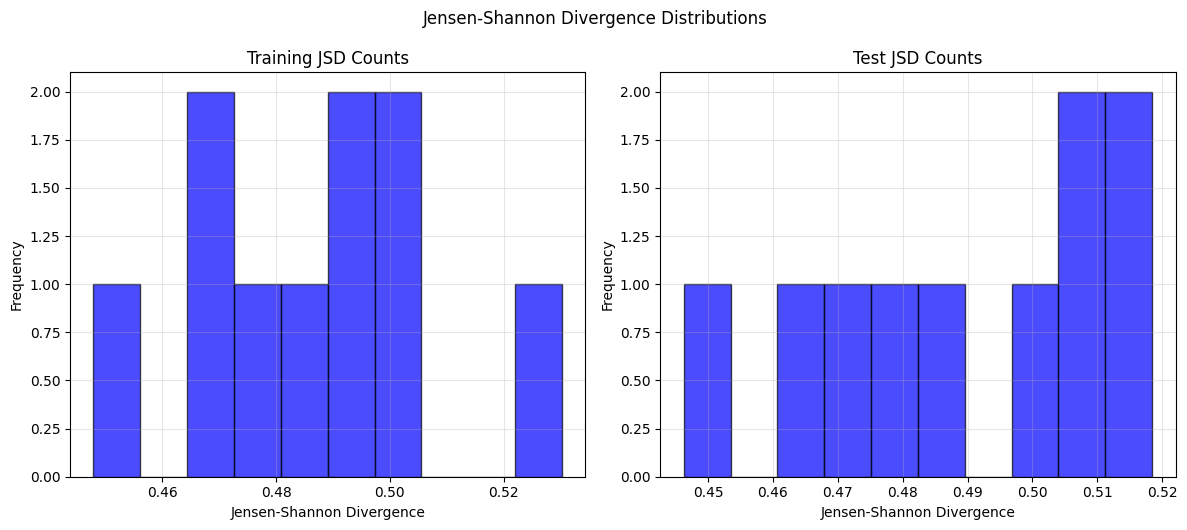

In [34]:
plot_jsd(real_data_train, real_data_test, samples.transpose(0,2,1), log_file_name)

## With Conditioning

In [35]:
with torch.no_grad():
    cond_samples_train = ddpm.sample(real_cond_data_train.shape[0], real_cond_data_train.to(device))
    cond_samples_train = cond_samples_train.cpu().numpy()

print(f"Samples shape: {cond_samples_train.shape}")

sampling loop time step: 100%|██████████| 500/500 [00:03<00:00, 138.89it/s]

Samples shape: (256, 10, 12)


## Train

### T-SNE and PCA

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


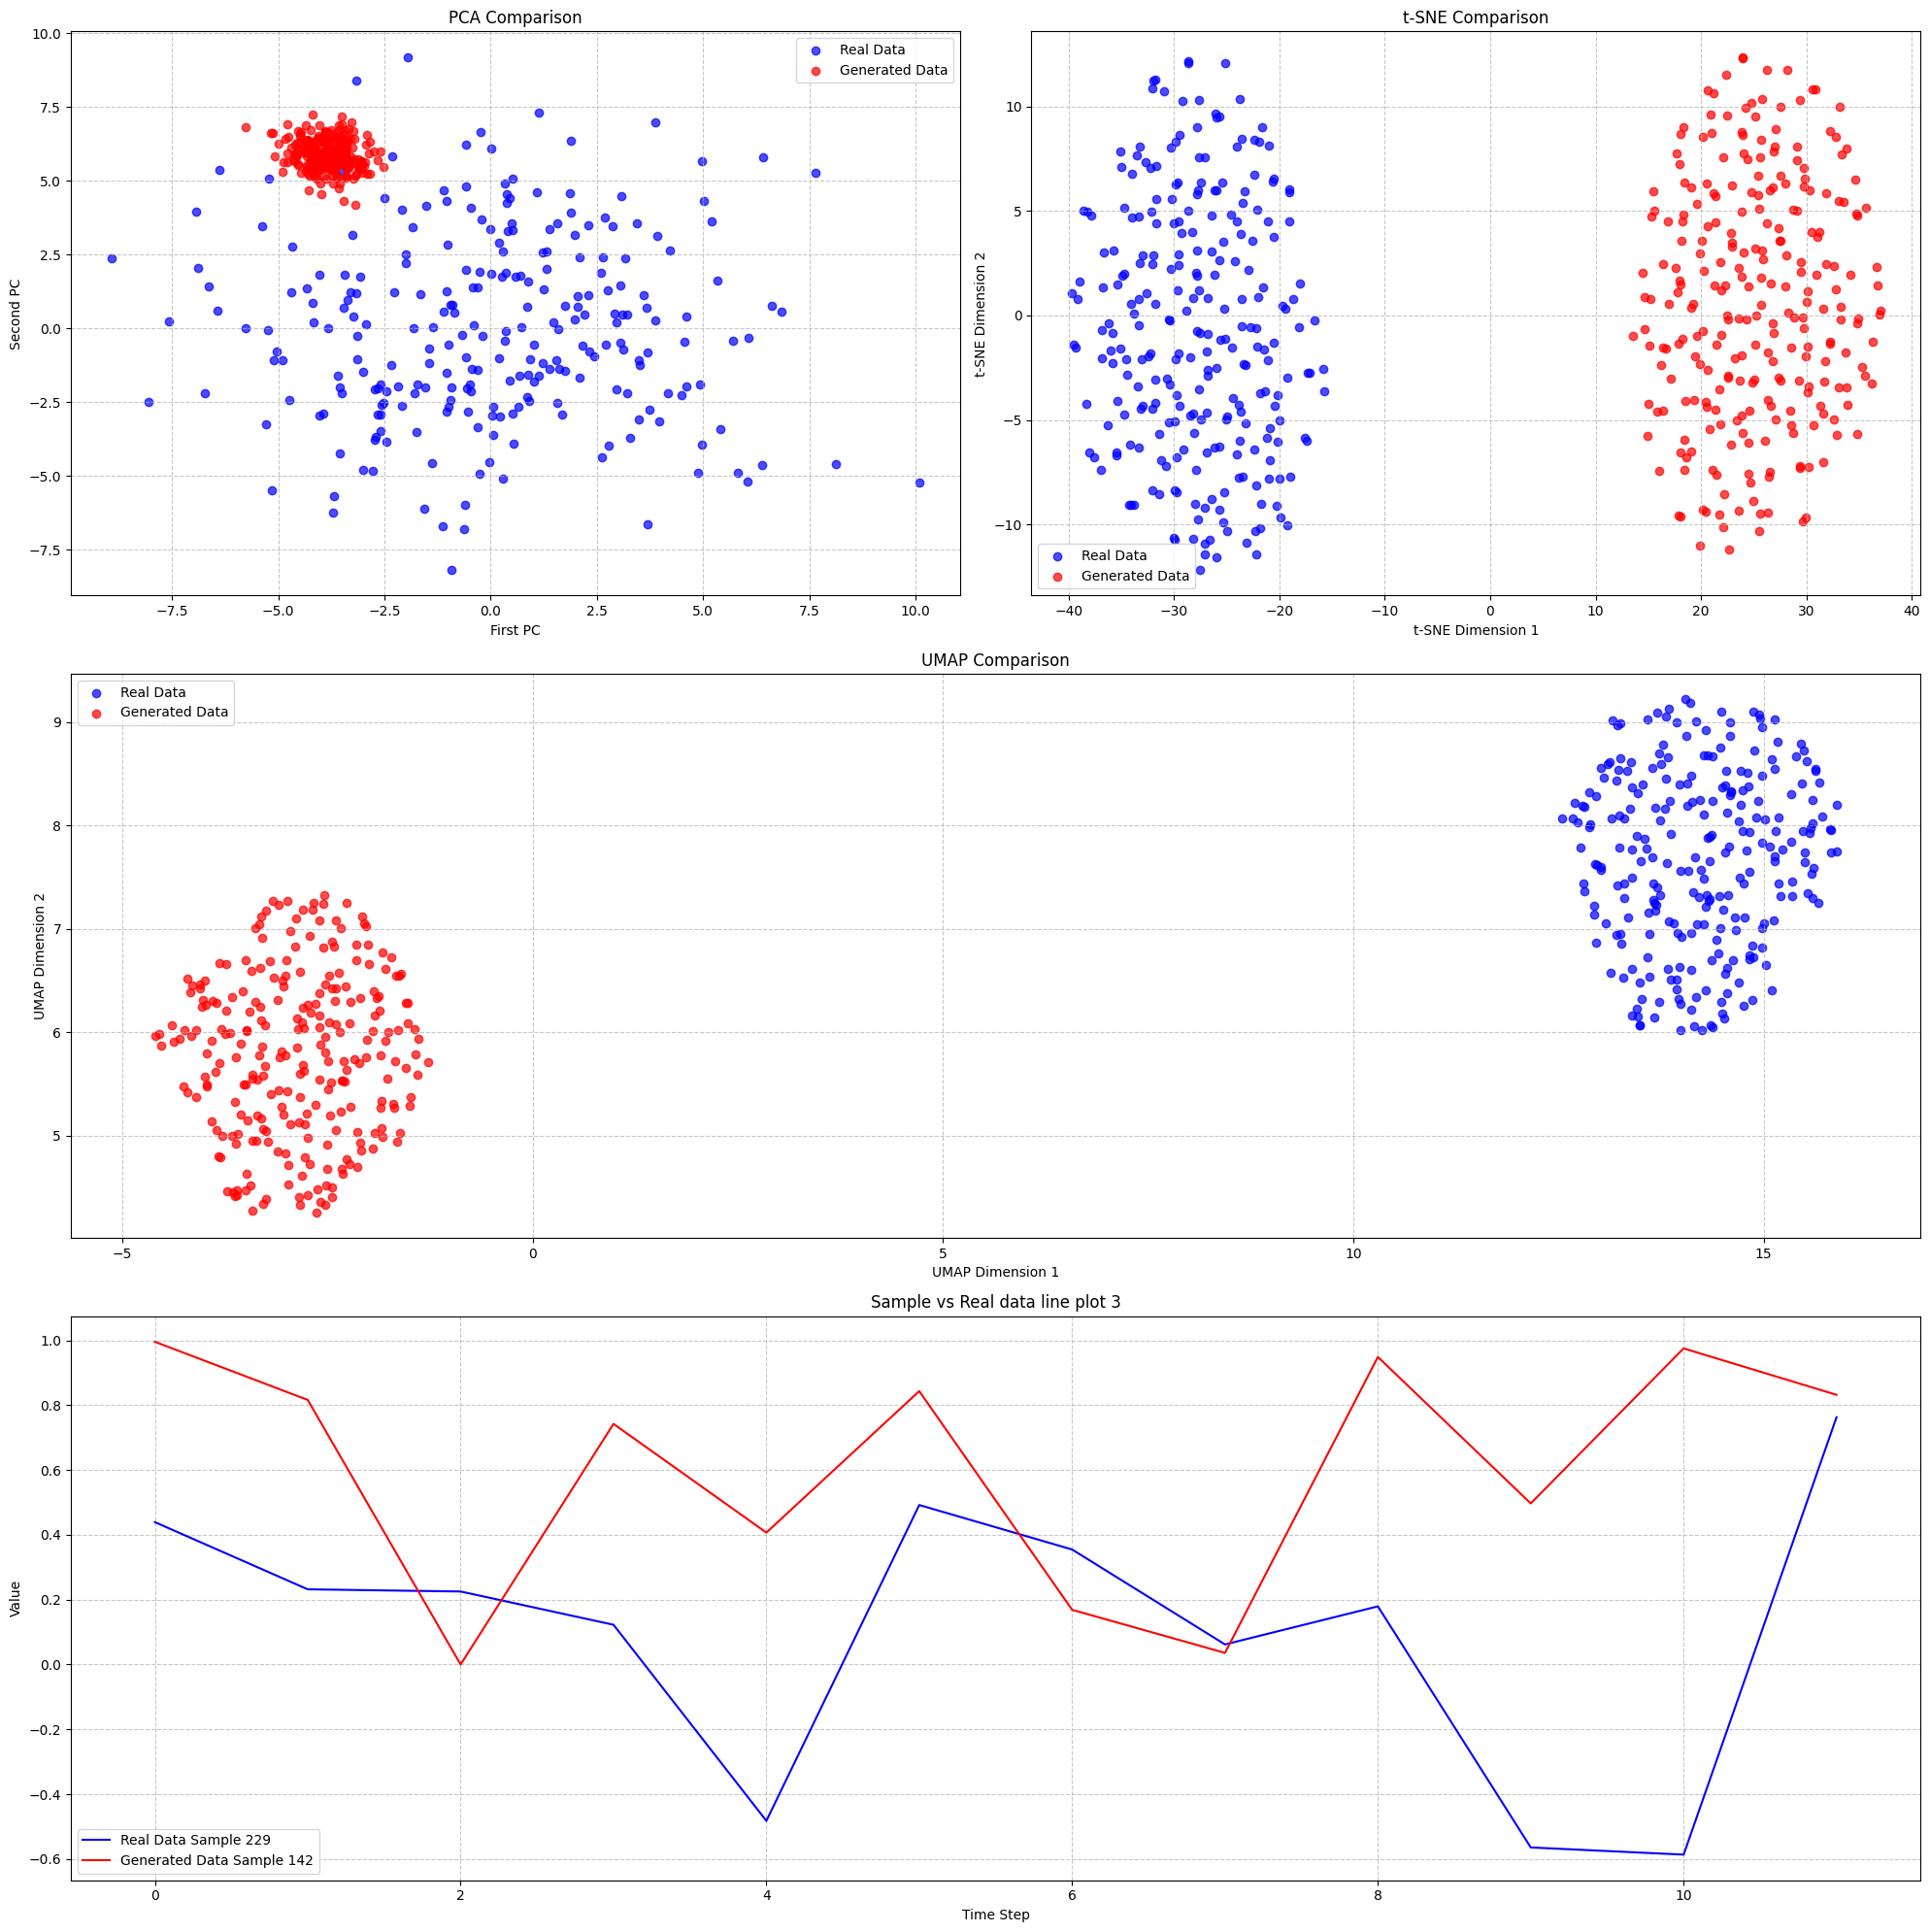

In [36]:
visual_evaluation(real_data_train, cond_samples_train, log_file_name, True, "train")

### Jensen-Shannon-Divergence

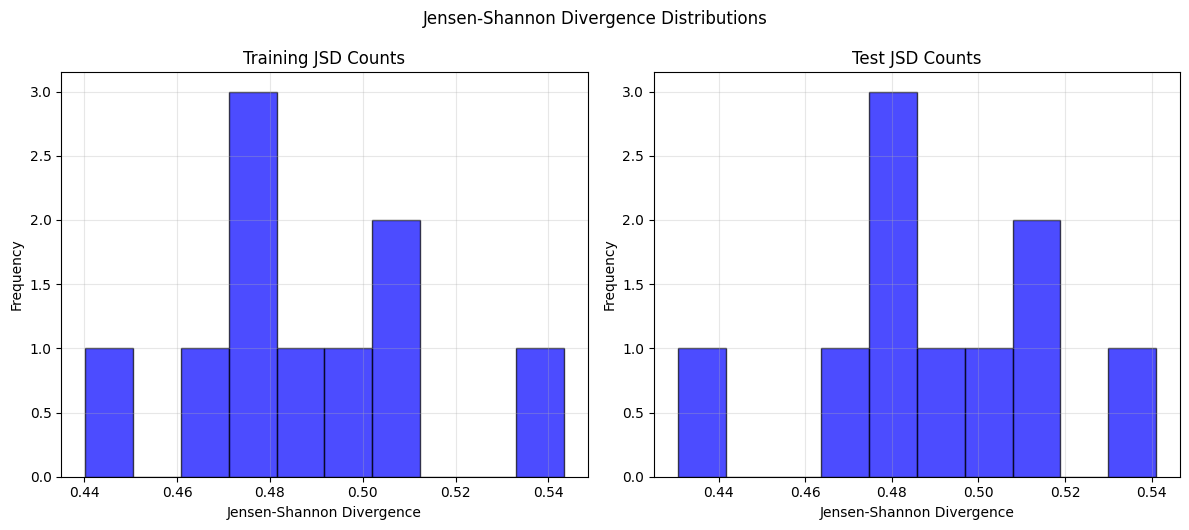

In [37]:
plot_jsd(real_data_train, real_data_test, cond_samples_train.transpose(0,2,1), log_file_name, cond=True)

## Test

In [38]:
with torch.no_grad():
    cond_samples_test = ddpm.sample(real_cond_data_test.shape[0], real_cond_data_test.to(device))
    cond_samples_test = cond_samples_test.cpu().numpy()

print(f"Samples shape: {cond_samples_test.shape}")

sampling loop time step: 100%|██████████| 500/500 [00:03<00:00, 133.54it/s]


Samples shape: (256, 10, 12)


c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


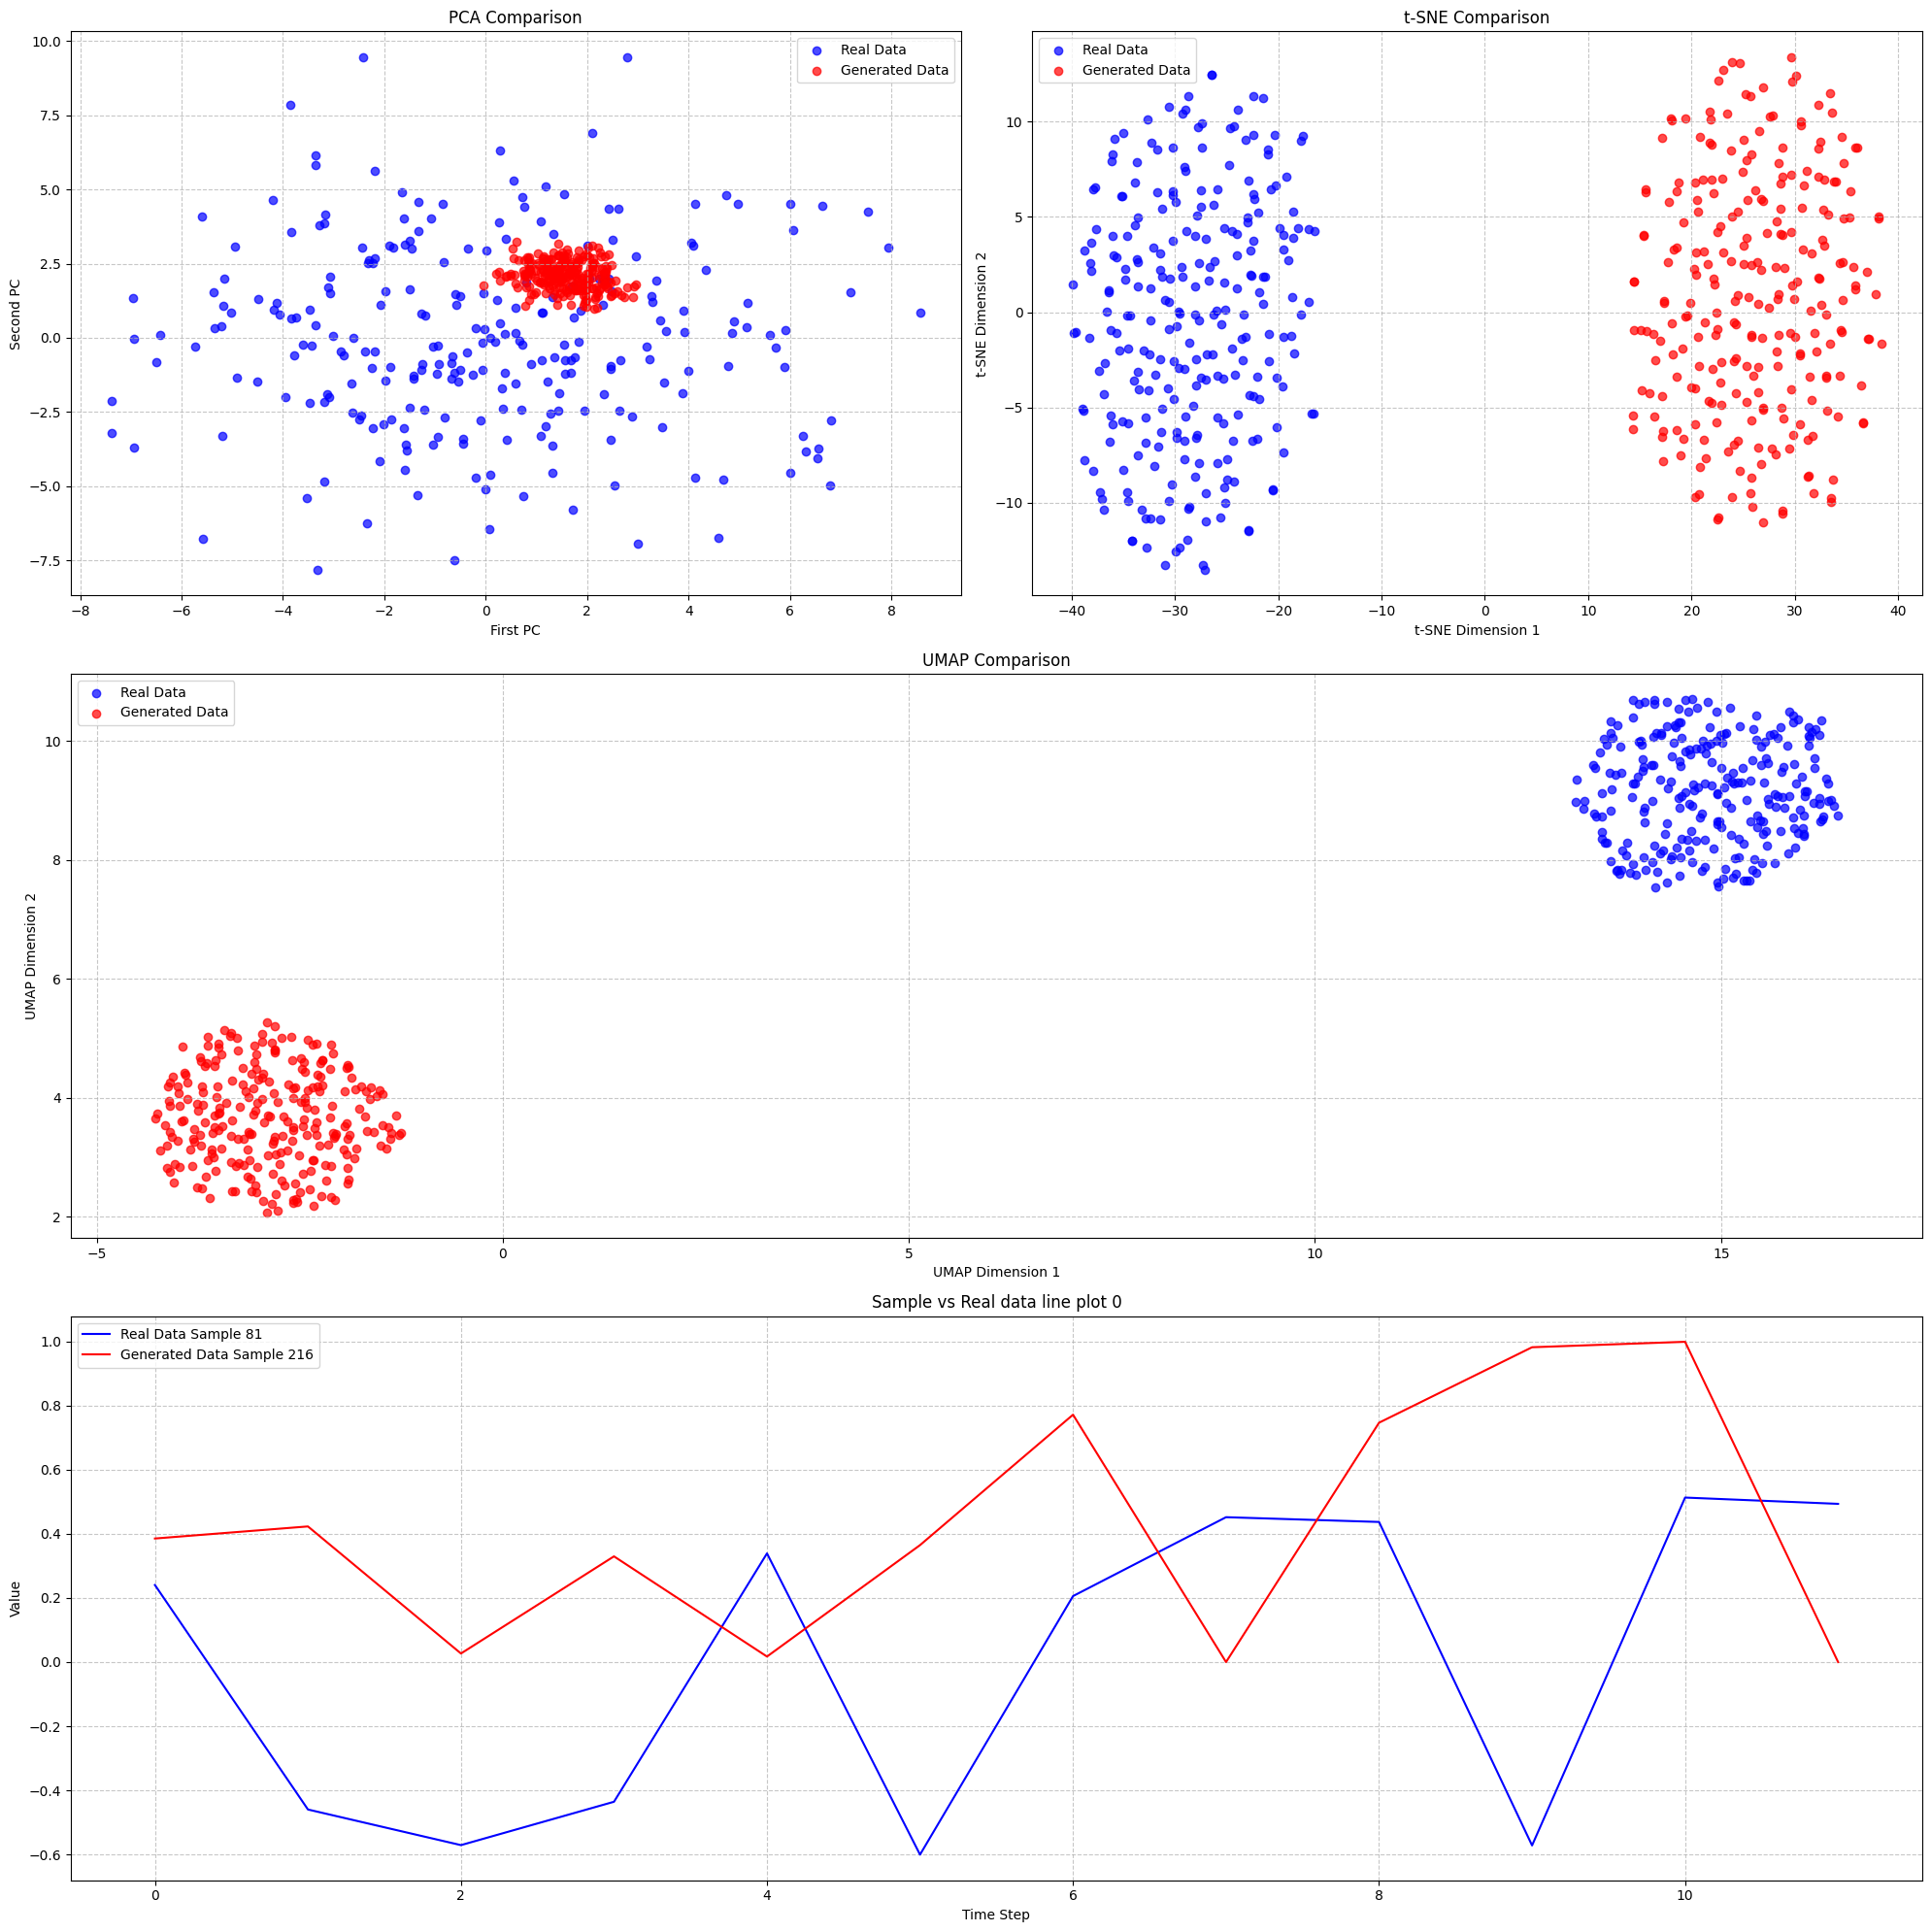

In [39]:
visual_evaluation(real_data_test, cond_samples_test, log_file_name, True, "test")

### Jensen-Shannon Divergence

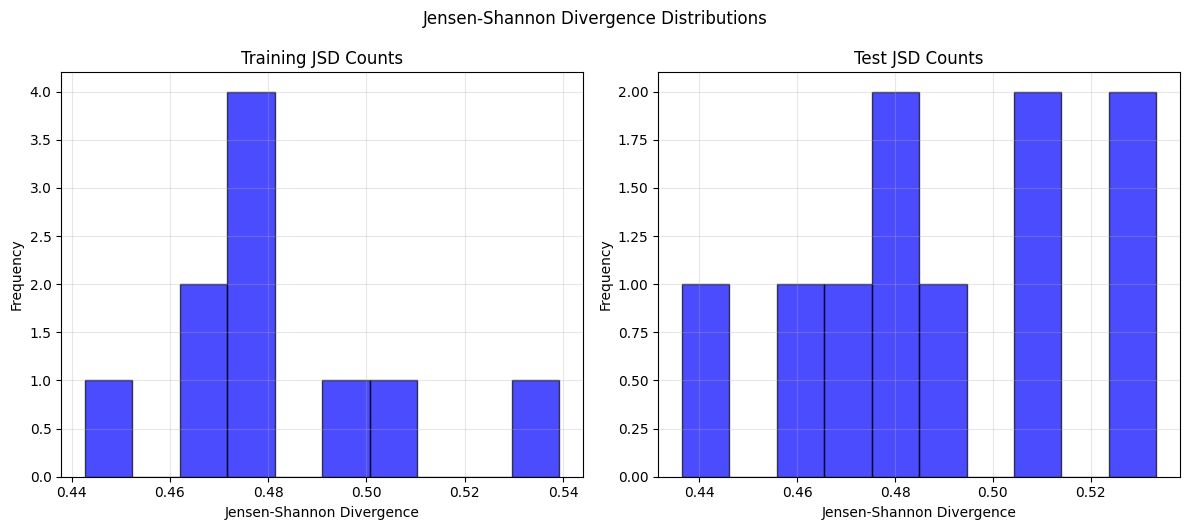

In [40]:
plot_jsd(real_data_train, real_data_test, cond_samples_test.transpose(0,2,1), log_file_name, cond=True)

# Logging

In [41]:
log_dir = "./logging/logs"
log_file_path = os.path.join(log_dir, log_file_name + ".txt")

with open(log_file_path, 'w') as log_file:
    log_file.write("Config:\n")
    for key, value in config.items():
        log_file.write(f"{key}: {value}\n")
    
    log_file.write("\n\nRMSE Values:\n")
    for rmse in rmse_list:
        log_file.write(f"{rmse}\n")

print(f"Log file created at: {log_file_path}")

Log file created at: ./logging/logs\BaseLine_mlp_2025-03-27-19-15.txt


In [21]:
#best_model = torch.load("./logging/weights/TransEncoder_te_2025-02-19-19-39/best_model_weights.pth")